# Compare different model outputs against empirical metrics of US MSA income distributions


Descriptive Characteristics of Empirical Distributions, against which to compare models:
- general shape
- decile scaling
- moments vs. population (especially 3rd)
    - NOTE: What about 1st moment? effectively, what about actual scaling behavior across size that won't show up?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sklearn.metrics as sk
import scipy.stats
from scipy.optimize import curve_fit
#from RegscorePy import *
from IPython.core.debugger import set_trace
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import lmfit 
#import import_ipynb
#import KEM_Rand

# Input from Data & Model Output
DATA:
Should be saved as pdfs of cities, formatted as 

MODEL OUTPUT:
Should be saved as numpy binary file, formatted as "<model-name>.npy"
The numpy object should be an array with each row representing a city output as a two-element list, with the first element being the population size and the second being an array of the income distribution of that model city.
    Example: 
        "KEM_randnet.npy" = array([[3, array([1, 2])],
                               [5, array([2, 3])]], dtype=object)
        , in which 3 and 5 are population sizes, and the arrays [1,2] and [2,3] are the respective income distributions of
          those cities 

## Input from Model

In [2]:
# CHANGE FILENAMES AND NAMES HERE FOR APPROPRIATE MODEL OUTPUTs
modelA_data = np.load("KEM_Rand_larger.npy",allow_pickle=True)
modelA_name = "Random IPDO Interacting Randomly (larger)"
modelB_data = np.load("KEM_Rand.npy",allow_pickle=True)
modelB_name = "Random IPDO Interacting Randomly"

In [3]:
m_incomes = {}
m_pops = {}
m_pops["A"] =    modelA_data[:,0]
m_incomes["A"] = modelA_data[:,1]
m_pops["B"] =    modelB_data[:,0]
m_incomes["B"] = modelB_data[:,1]

## Input from Data

In [13]:
data = pd.read_csv("empiricalAnalysis/CTScalingFiles/ct.distr.csv")
idmappings = pd.read_excel("empiricalAnalysis/CTScalingFiles/cbsaidmappings.xls").set_index("CBSA Code")


# maps MSA id to census tract incomes
income_lists = {}
# maps MSA id to census tract population
pops = {}
fullpops = {}
cts = set()
# populations of whole cities (DONE: Cross-check with other data)
city_pops = {}

# If True, will only read in data from MSAs (not Micropolitan SAs). If False, includes all data
ONLY_MSA = True

for _,ct in data.iterrows():
    msa = ct['msa']
    ct_id = ct["ct"]
    
    msa = str(msa)
    metro_micro_lbl = idmappings["Metropolitan/Micropolitan Statistical Area"][msa]
    if not isinstance(metro_micro_lbl,str):
        metro_micro_lbl = list(metro_micro_lbl)[0]
    metro = "Metro" in metro_micro_lbl
    
    # skip over entry if it's a Micro area and you've set the script to only read Metro (not Micro)
    if ONLY_MSA and not metro:
        continue
    
    #NOTE on data: "meandollars is total ct income / # workers... "
    ct_inc = ct["ct.meandollars"]
    pop = ct["ct.totalworkers"]
    fullpop = ct["ct.population"]
    if (ct["ct"],msa) in cts:
        print("WARNING! Found Double census tract id: "+str(ct["ct"]))
        set_trace()
    cts.add((ct["ct"],msa))
    
    if msa not in city_pops:
        city_pops[msa] = ct["pop.sum"]
    
    if msa not in income_lists or msa not in pops:
        income_lists[msa] = []
        pops[msa] = []
        fullpops[msa] = []
    income_lists[msa].append(ct_inc)
    pops[msa].append(pop)
    fullpops[msa].append(fullpop)

In [14]:
e_pops = list(city_pops.values())
e_ctpops = list(fullpops.values())
e_incomes = list(income_lists.values())

# General Shape (TODO: Just plot kde_pdfs I already have)

In [ ]:
  
fig = plt.figure()
def animate(i):
    #label = label + ': G=' + str(round(gini(population), 2))
    plt.cla()
    msa = sorted_cpops_arr[i]
    x,y = kde_distr[msa]
    x = np.array(x)
    y = np.array(y)
    max_x,max_y = x[np.argmax(y)],np.max(y)
    newx,newy = x*(mean_max_x/max_x),y*(mean_max_y/max_y)
    scaled_distr[msa] = newx,newy
    pop = city_pops[msa]
    lbl = "pop: "+str(pop)
    plt.plot(newx,newy,label=lbl)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(right=x_lim)
    plt.ylim(bottom=y_lim_b,top=y_lim_t)
    plt.legend()
    plt.grid(True)

anim = FuncAnimation(fig, animate, #init_func=init,
                               frames=n_cities)#), interval=20)#, blit=True)
                               #frames=int(n_cities/100))#), interval=20)#, blit=True)

HTML(anim.to_jshtml())



# Moment distribution

## Model

MODEL: A
completed pop 100
completed pop 500
completed pop 1000
completed pop 2000
completed pop 3000
completed pop 4000
completed pop 5000
completed pop 6000
completed pop 7000
completed pop 8000
completed pop 9000
completed pop 10000
completed pop 11000
completed pop 12000
> <ipython-input-12-1896e8730b91>(51)<module>()
     49     set_trace()
     50     scale_y = {
---> 51           1:1.,
     52           2:1.,
     53           3:1.,

ipdb> moments
{'A': {1: [47.717213573925086, 50.47761008740152, 50.544894940289474, 49.845954271252914, 50.187838103562726, 49.76188061730029, 50.36339279801587, 50.13728378927621, 49.36062345848483, 49.715488049955056, 49.95299837249334, 49.64921077070217, 49.70635638208147, 50.12957475396915], 2: [4560.978972536931, 4492.808752226839, 4504.045218393951, 4469.06134934035, 4513.702668318522, 4306.1663578299385, 4485.610642877238, 4319.976644756809, 4216.982768249103, 4414.473563643176, 4370.612408578016, 4365.401103371519, 4129.036747197902, 4478.89

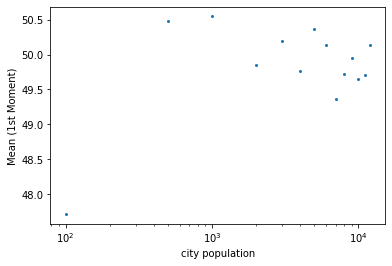

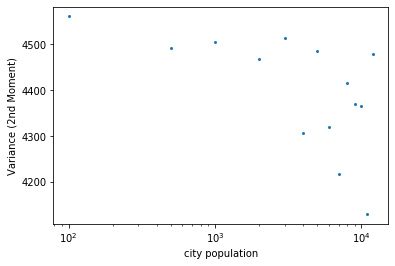

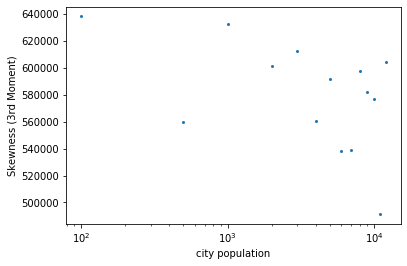

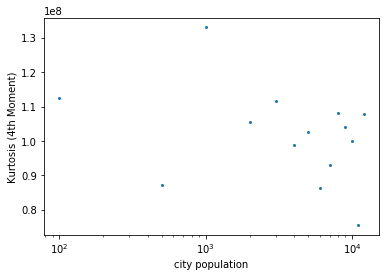

MODEL: B
completed pop 100
completed pop 500
completed pop 1000
completed pop 2000
completed pop 4000
completed pop 10000
> <ipython-input-12-1896e8730b91>(49)<module>()
     47         cpops[model].append(psize)
     48 
---> 49     set_trace()
     50     scale_y = {
     51           1:1.,

ipdb> c


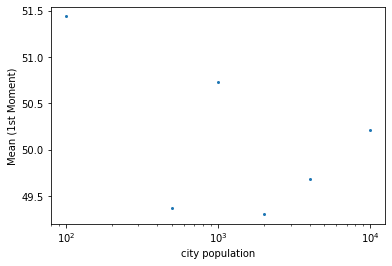

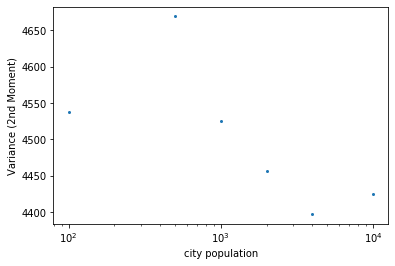

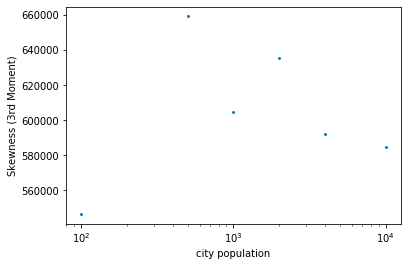

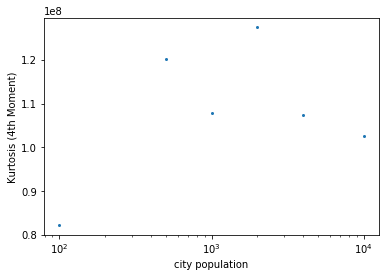

In [12]:
import scipy.stats
import seaborn as sns

m_kdes = {}
for model in ["A","B"]:
    m_kdes[model] = {}

# create kde pdfs
for model in ["A","B"]:
    for pop,income in zip(m_pops[model],m_incomes[model]):
        m_kdes[model][pop] = scipy.stats.gaussian_kde(income)#,bw_method=wide_silverman)


class custom_distribution(scipy.stats.rv_continuous):
    def _pdf(self, x, msa):
        #print("in pdf",x)
#         if first:
#             print("in pdf,x = ",x,"msa=",msa,"model = ", model)
        ret = m_kdes[model][msa[0]](x[0])
        #print(ret)
        #print("ret=",ret)
        return ret

distribution = custom_distribution(momtype=0)


# maps moment number n to list of those moments
moments = {}
cpops = {}

for model in ["A","B"]:
    print("MODEL:",model)
    moments[model] = {}
    cpops[model] = []
    first = True
    for psize in m_pops[model]: 
        for n in range(1,5):
            if n not in moments[model]:
                moments[model][n] = []
#             set_trace()
            # FIXME: not running for every city in model, only returning one value
#             print(moments)
            moments[model][n].append(distribution.moment(n,psize))
            first = False
#             print("moment: n, val,pop:",n,moments[model][n],psize)
        print("completed pop",psize)
        cpops[model].append(psize)
    
    scale_y = {
          1:1.,
          2:1.,
          3:1.,
          4:1.,
          5:1.
#         1:1.,
#         2:.5,
#         3:.3,
#         4:.3,
#         5:.15
    }

    #TODO: What's going on with the moments that evaluate to zero???

    for n in range(1,5):
        plt.figure()
        plt.xlabel("city population")
        lbl = "nth moment, n = " + str(n) 
        if n == 2:
            lbl = "Variance (2nd Moment)"
        elif n == 1:
            lbl = "Mean (1st Moment)"
        elif n == 3:
            lbl = "Skewness (3rd Moment)"
        elif n == 4:
            lbl = "Kurtosis (4th Moment)"
        plt.ylabel(lbl)
        # TODO: fit regressions in log-linear space, calculate R^2 & p-value
        plt.plot(cpops[model],moments[model][n],'o',markersize=2)
        bottom,top = plt.ylim()
        plt.ylim((bottom,scale_y[n]*top))
        #plt.yscale("log")
        plt.xscale("log")
        plt.show()
        plt.close()


## Empirical

### First, calculate kde pdfs

In [16]:
kde_pdfs = {}

def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale



for income_list,pop,cpop in zip(e_incomes,e_ctpops,e_pops):
    income_list = np.array(income_list)
    pop = np.array(pop)/sum(pop)    
    kernel = scipy.stats.gaussian_kde(income_list,weights=pop,bw_method=wide_silverman)
    kde_pdfs[cpop] = kernel.pdf


## calculate moments using pdfs generated by kde for each city
Uses scipy.stats.rv_continuous.moment
NOTE: Moments change significantly from raw data to kde-generated pdf. We assume that these changes are representative of the true distributions


    FIXME: Some moments are being returned as zero

In [18]:

class custom_distribution(scipy.stats.rv_continuous):
    def _pdf(self, x, msa):
        #print("in pdf,x = ",x,"msa=",msa)
        #print("in pdf",x)
        ret = kde_pdfs[msa[0]](x[0])
        #print(ret)
        #print("ret=",ret)
        return ret

distribution = custom_distribution(momtype=0)

# maps moment number n to list of those moments
moments = {}
cpops = []

for pop in kde_pdfs: 
#     for i in range(100):
#         print(i)
#         sample = distribution.rvs(msa)
#         samples.append(sample)
        
#     break

    #print("sample:",sample)
    for n in range(1,6):
        if n not in moments:
            moments[n] = []
        moments[n].append(distribution.moment(n,pop))
    cpops.append(pop)
        
#     other_std = np.std(income_lists[msa])
#     #print(std,other_std)
#     stds.append(std)
#     raw_stds.append(other_std)
#     #means.append(distribution.moment(1,msa))


/home/jake/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1688: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  args=(m,)+args)[0]


### Analyze distribution moments vs. city size

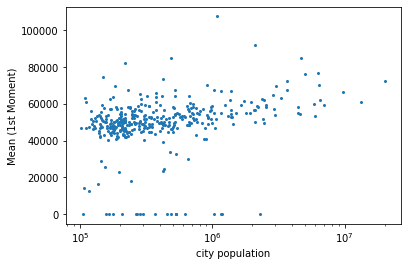

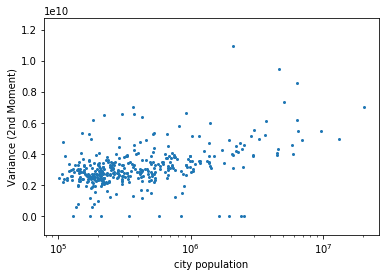

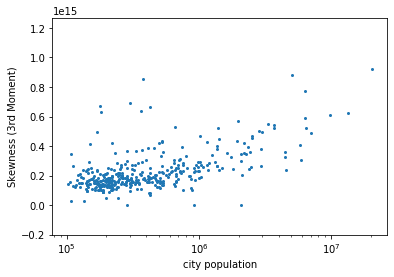

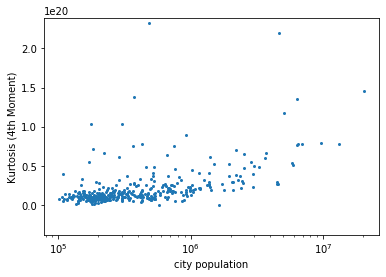

In [19]:
# moment_p = moments
# cpops_p = cpops

scale_y = {
    1:1.,
    2:.5,
    3:.3,
    4:.3,
    5:.15
}

#TODO: What's going on with the moments that evaluate to zero???

for n in range(1,5):
    plt.figure()
    plt.xlabel("city population")
    lbl = "nth moment, n = " + str(n) 
    if n == 2:
        lbl = "Variance (2nd Moment)"
    elif n == 1:
        lbl = "Mean (1st Moment)"
    elif n == 3:
        lbl = "Skewness (3rd Moment)"
    elif n == 4:
        lbl = "Kurtosis (4th Moment)"
    plt.ylabel(lbl)
    # TODO: fit regressions in log-linear space, calculate R^2 & p-value
    plt.plot(cpops,moments[n],'o',markersize=2)
    bottom,top = plt.ylim()
    plt.ylim((bottom,scale_y[n]*top))
    #plt.yscale("log")
    plt.xscale("log")
    plt.show()
    plt.close()
#plt.hist(samples)


# Decile Scaling

## Empirical

[ 8.25097804 -0.01176748]
[ 8.27880077e+00 -9.97510468e-04]
[8.19407966 0.01221861]
[8.12291218 0.0230467 ]
[8.0292634  0.03503435]
[7.93495772 0.04706884]
[7.79697342 0.06278315]
[7.67005023 0.07888204]
[7.49029027 0.10159293]
[6.96151438 0.16120646]


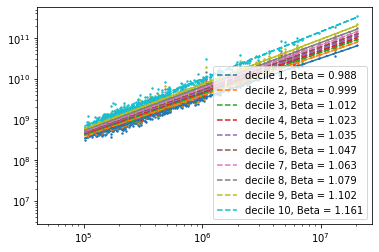

In [33]:
# maps int (1-10) to pair (list of income_pp,list of city size)
deciles = {}
for i in range(1,11):
    deciles[i] = ([],[])

# empirical case:
for e_income,e_pop,e_ctpop in zip(e_incomes,e_pops,e_ctpops):

        #split into deciles
        sum_pop = sum(e_ctpop)
        pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
        cumulative_pop = 0.
        current_decile = 1
        # summed population and income for current decile
        decile_pop = 0.
        decile_inc = 0.
        # sort by income
        e_income,e_ctpop = (list(t) for t in zip(*sorted(zip(e_income, e_ctpop))))
        for ctpop, ctinc in zip(e_ctpop,e_income):
            cumulative_pop += ctpop
            decile_pop += ctpop
            decile_inc += ctinc*ctpop
            if cumulative_pop >= pop_cutoffs[(current_decile - 1)]:
    #             if cumulative_pop == pop_cutoffs[9]:
    #                 print("finish reached")
                current_decile += 1
                #store in deciles
                correction = (sum_pop/10.)/(decile_pop)
                decile_inc *= correction 
                #print(correction)
                #print("Decile:",decile_pop,"full/10:",(sum_pop/10.),"with correction",decile_pop*correction)
                
                deciles[(current_decile-1)][0].append(decile_inc)
                deciles[(current_decile-1)][1].append(e_pop)
                #reset
                decile_pop = 0
                decile_inc = 0

#         sum_inc = np.sum(np.array(income_list)*np.array(pop))

        
def standardModelFunc(x,y0,delta):
    return y0*(x**(1+delta))
def standardLogResidual(params, x, true_data):
    model = standardModelFunc(x,params['y0'],params['delta'])
    return np.log(true_data)-np.log(model)
        
def standardLogMod(x,logy0,delta):
    return logy0+x*(1+delta)
    
plt.figure()
ax = plt.gca()
decileFits = {}
decileModels = {}
decileParams = {}
for i in range(1,11):
    x= list(deciles[i][1])
    y = list(deciles[i][0])
    #print("decile:",i,"x,y = ",x,y)
    plt.scatter(x,y,s=2)
    decileParams[i] = lmfit.Parameters()
    decileParams[i].add_many(('y0',8*list(y)[0]/list(x)[0],True,0,1),('delta',0.,True))
    

    decileModels[i] = lmfit.Model(standardModelFunc)
    decileFits[i] = lmfit.minimize(standardLogResidual, decileParams[i], args=(x, y))
    decileParams[i] = decileFits[i].params
    
    #using curve_fit
    logx = np.log(x)
    logy = np.log(y)
    coeff, var = curve_fit(standardLogMod, logx, logy)
    
    lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
#     print(coeff)
    fity = np.exp(np.array(coeff[0],dtype=np.float128))*x**(1+coeff[1])
    #print(x,fity)
    ax.plot(x, fity,'--',label=lbl,markersize=1)
    #ax.plot(x,decileModels[i].eval(decileParams[i],x=x),'--',label=lbl)
    

ax.set_yscale("log")
ax.set_xscale("log")
plt.legend()


## Model

TODO: Compare what exactly???

A
population: 100 decile: 2 sum income: 90.46995975813816
population: 100 decile: 3 sum income: 146.1011843077806
population: 100 decile: 4 sum income: 225.78800661968495
population: 100 decile: 5 sum income: 272.57458085643356
population: 100 decile: 6 sum income: 310.7800238239929
population: 100 decile: 7 sum income: 372.8125045409597
population: 100 decile: 8 sum income: 447.4275674807495
population: 100 decile: 9 sum income: 526.5931952162156
population: 100 decile: 10 sum income: 795.6529010010786
population: 100 decile: 11 sum income: 1583.5214337874747
sum_inc: 4771.721357392508
pop: 100
population: 500 decile: 2 sum income: 380.29593659659287
population: 500 decile: 3 sum income: 692.3717972294314
population: 500 decile: 4 sum income: 1049.5616650625184
population: 500 decile: 5 sum income: 1424.2189868503795
population: 500 decile: 6 sum income: 1746.2916887492624
population: 500 decile: 7 sum income: 2158.227207072775
population: 500 decile: 8 sum income: 2671.4928619392817


B
population: 100 decile: 2 sum income: 118.88752627169102
population: 100 decile: 3 sum income: 170.98198586608493
population: 100 decile: 4 sum income: 228.31824563611295
population: 100 decile: 5 sum income: 303.94910716789104
population: 100 decile: 6 sum income: 359.90353898706155
population: 100 decile: 7 sum income: 430.9556947789626
population: 100 decile: 8 sum income: 535.4199404016978
population: 100 decile: 9 sum income: 635.3569806829933
population: 100 decile: 10 sum income: 899.8897283417792
population: 100 decile: 11 sum income: 1460.0886305319855
sum_inc: 5143.7513786662585
pop: 100
population: 500 decile: 2 sum income: 368.9781458116228
population: 500 decile: 3 sum income: 672.1822858570571
population: 500 decile: 4 sum income: 992.0824846374218
population: 500 decile: 5 sum income: 1318.7619651849302
population: 500 decile: 6 sum income: 1603.9569397469293
population: 500 decile: 7 sum income: 2019.9057352441193
population: 500 decile: 8 sum income: 2529.00201390314

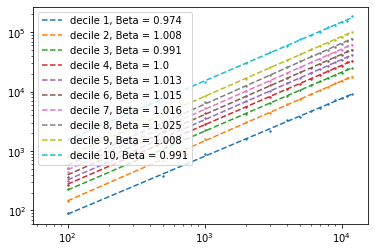

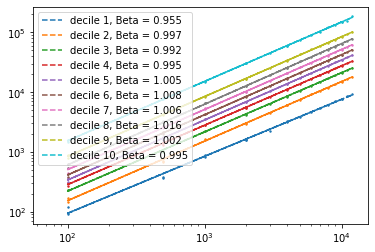

In [9]:
# maps int (1-10) to pair (list of income_pp,list of city size)
deciles = {}
for i in range(1,11):
    deciles[i] = ([],[])

for model in ["A","B"]:
    print(model)
    fake_ctpops = np.ones((len(m_incomes[model]),len(m_incomes[model][0])))
    for m_income,m_pop in zip(m_incomes[model],m_pops[model]):

            m_ctpop = np.ones((len(m_income)))
#             print(m_ctpop)
#             set_trace()
            #split into deciles
            sum_pop = sum(m_ctpop)
            pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
            cumulative_pop = 0.
            current_decile = 1
            # summed population and income for current decile
            decile_pop = 0.
            decile_inc = 0.
            # sort by income
            m_income,m_ctpop = (list(t) for t in zip(*sorted(zip(m_income, m_ctpop))))
            for ctpop, ctinc in zip(m_ctpop,m_income):
                cumulative_pop += ctpop
                decile_pop += ctpop
                decile_inc += ctinc*ctpop
                if cumulative_pop >= pop_cutoffs[(current_decile - 1)]:
#                     set_trace()
        #             if cumulative_pop == pop_cutoffs[9]:
        #                 print("finish reached")
                    current_decile += 1
                    #store in deciles
                    correction = (sum_pop/10.)/(decile_pop)
                    decile_inc *= correction 
                    if abs(1.0-correction) > 0.0001:
                        print("correction is not equal to 1!")
#                     print("population:", m_pop, "decile:",current_decile,"sum income:",decile_inc)
                    #print(correction)
                    #print("Decile:",decile_pop,"full/10:",(sum_pop/10.),"with correction",decile_pop*correction)

                    deciles[(current_decile-1)][0].append(decile_inc)
                    deciles[(current_decile-1)][1].append(m_pop)
                    #reset
                    decile_pop = 0
                    decile_inc = 0

            sum_inc = np.sum(np.array(m_income)*np.array(m_ctpop))
#             print("sum_inc:",sum_inc)
#             print("pop:",m_pop)


    def standardModelFunc(x,y0,delta):
        return y0*(x**(1+delta))
    def standardLogResidual(params, x, true_data):
        model = standardModelFunc(x,params['y0'],params['delta'])
        return np.log(true_data)-np.log(model)

    def standardLogMod(x,logy0,delta):
        return logy0+x*(1+delta)

    plt.figure()
    ax = plt.gca()
    decileFits = {}
    decileModels = {}
    decileParams = {}
    for i in range(1,11):
        x= list(deciles[i][1])
        y = list(deciles[i][0])
        #print("decile:",i,"x,y = ",x,y)
        plt.scatter(x,y,s=2)
        decileParams[i] = lmfit.Parameters()
        decileParams[i].add_many(('y0',8*list(y)[0]/list(x)[0],True,0,1),('delta',0.,True))


        decileModels[i] = lmfit.Model(standardModelFunc)
        decileFits[i] = lmfit.minimize(standardLogResidual, decileParams[i], args=(x, y))
        decileParams[i] = decileFits[i].params

        #using curve_fit
        logx = np.log(x)
        logy = np.log(y)
        coeff, var = curve_fit(standardLogMod, logx, logy)

        lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
    #     print(coeff)
        fity = np.exp(np.array(coeff[0],dtype=np.float128))*x**(1+coeff[1])
        #print(x,fity)
        ax.plot(x, fity,'--',label=lbl,markersize=1)
        #ax.plot(x,decileModels[i].eval(decileParams[i],x=x),'--',label=lbl)


    ax.set_yscale("log")
    ax.set_xscale("log")
    plt.legend()


[5143.751378666259, 24685.94262902863, 50733.77662110774, 98610.14195760473, 198736.29433335946, 502115.0883107309]


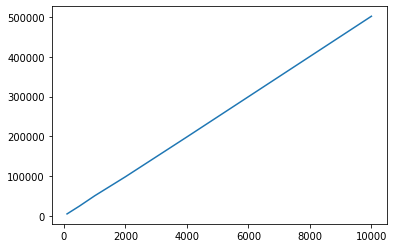

In [12]:
# m_incomes["A"] = np.array(m_incomes["A"])
# print(m_incomes["A"])
sum_incs = list(map(lambda x: np.sum(x),m_incomes["A"]))
print(sum_incs)
plt.plot(m_pops["A"],sum_incs)